## Classification and Regression Trees

This chapter describes a flexible data-driven method that can be used for both classification (called *classification tree*) and prediction (called *regression tree*). Among the data-driven methods, trees are the most transparent and easy to interpret. Trees are based on separating records into subgroups by  creating splits on predictors. These splits create logical rules that are transparent and easily understandable, for example, "IF Age < 55 AND Education > 12 THEN class = 1". The resulting subgroups should be more homogeneous in terms of the outcome variable, thereby creating useful prediction or classification rules. We discuss the two key ideas underlying trees: *recursive partitioning* (for constructing the tree) and *pruning* (for cutting the tree back). In the context of tree construction, we also describe a few metrics of homogeneity that are popular in tree algorithms, for determining the homogeneity of the resulting subgroups of records. We explain that limiting tree size is a useful strategy for avoiding overfitting and show how it is done. We also describe alternative strategies for avoiding overfitting. As with other data-driven methods, trees require large amounts of data. However, once constructed, they are computationally cheap to deploy even on large samples. They also have other advantages such as being highly automated, robust to outliers, and able to handle missing values. In addition to prediction and classification, we describe how trees can be used for dimension reduction. Finally, we introduce *random forests* and *boosted trees*, which combine results from multiple trees to improve predictive power.

## Imports

In this chapter, we will use pandas for data handling, scikit-learn for the models, and matplotlib and pydotplus for visualization. We will also make use of the utility functions from the Python Utilities Functions Appendix. Use the following import statements for the Python code in this chapter.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Introduction

If one had to choose a classification technique that performs well across a wide range of situations without requiring much effort from the analyst while being readily understandable by the consumer of the analysis, a strong contender would be the tree methodology developed by Breiman et al. (1984). We discuss this classification procedure first, then in later sections we show how the procedure can be extended to prediction of a numerical outcome. The program that Breiman et al. created to implement these procedures was called CART (Classification And Regression Trees). A related procedure is called C4.5.

What is a classification tree? The figure below shows a tree for classifying bank customers who receive a loan
offer as either acceptors or nonacceptors, based on information such as their income, education level,
and average credit card expenditure.

![title](../images/example-of-tree-classifying-bank-customers-as-loan-acceptors-or-non-acceptors.png)

### Tree Structure

We have two types of nodes in a tree: decision (=splitting) nodes and terminal nodes. Nodes that have successors are called *decision nodes* because if we were to use a tree to classify a new record for which we knew only the values of the predictor variables, we would "drop" the record down the tree so that at each decision node, the appropriate branch is taken until we get to a node that has no successors. Such nodes are called the *terminal nodes* (or *leaves* of the tree), and represent the partitioning of the data by predictors.

It is useful to note that the type of trees grown by Python's `DecisionTreeClassifier()` method, also known as CART or *binary trees*, have the property that the number of terminal nodes is exactly one more than the number of decision nodes. When using the `export_graphviz()` function from `scikit-learn`, nodes are represented as boxes. The
function has a large number of arguments that allow controlling the final graph. We use the utility function `plotDecisionTree` from the utility module for plotting the graphs in this chapter. With the chosen settings, all nodes contain information about the number of records in that node (samples), the distribution of the classes, and the majority class of that node. In addition, we color the nodes by the average value of the node for regression or purity of node for classification.

For decision nodes, the name of the predictor variable chosen for splitting and its splitting value appear at the top. Of the two child nodes connected below a decision node, the left box is for records that meet the splitting condition ("True"), while the right box is for records that do not meet it ("False").

### Decision Rules

One of the reasons that tree classifiers are very popular is that they provide easily understandable decision rules (at least if the trees are not too large). Consider the tree in the example. The *terminal* odes are colored orange or blue corresponding to a nonacceptor (0) or acceptor (1) classification. The condition at the top of each splitting node gives the predictor and its splitting value for the split (e.g. *Income* ≤ 110.5 in the top node). *samples=* shows the number of records in that node, and *values=* shows the counts of the two classes (0 and 1) in that node; the labels are only shown in the top node. This tree can easily be translated into a set of rules for classifying a bank customer. For example, the bottom-left node under the "Family" decision node in this tree gives us the following rule:

    IF(Income > 110.5) AND (Education ≤ 1.5) AND (Family ≤ 2.5)
    THEN Class = 0 (nonacceptor).

### Classifying a New Record

To classify a new record, it is "dropped" down the tree. When it has dropped all the way down to a terminal node, we can assign its class simply by taking a "vote" (or average, if the outcome is numerical) of all the training data that belonged to the terminal node when the tree was grown. The class with the highest vote is assigned to the new record. For instance, a new record reaching the leftmost terminal node in above figure, which has a majority of records that belong to the 0 class, would be classified as "nonacceptor". Alternatively, we can convert the number of class 0 records in the node to a proportion (propensity) and then compare the proportion to a user-specified cutoff value. In a binary classification situation (typically, with a success class that is relatively rare and of particular interest), we can also establish a lower cutoff to better capture those rare successes (at the cost of lumping in more failures as successes). With a lower cutoff, the votes for the *success* class only need attain that lower cutoff level for the entire terminal node to be classified as a *success*. The cutoff therefore determines the proportion of votes needed for determining the terminal node class. See [Evaluating Predictive Performance](evaluating-predictive-performance.ipynb) for further discussion of the use of a cutoff value in classification, for cases where a single class is of interest.

In the following sections, we show how trees are constructed and evaluated.

## Classification Trees

The key idea underlying tree construction is recursive partitioning of the space of the predictor variables. A second important issue is avoiding over-fitting. We start by explaining recursive partitioning and then describe approaches for evaluating and fine-tuning trees while avoiding overfitting.

### Recursive Partitioning

Let us denote the outcome variable by $Y$ and the input (predictor) variables by $X_1$, $X_2$, $X_3$, ..., $X_p$. In
classification, the outcome variable will be a categorical variable. Recursive partitioning divides up the *p*-dimensional space of the $X$ predictor variables into nonoverlapping multidimensional rectangles. The predictor variables here are considered to be continuous, binary, or ordinal. This division is accomplished recursively (i.e., operating on the results of prior divisions). First, one of the predictor variables is selected, say $X_i$, and a value of $X_i$, say $s_i$, is chosen to split the *p*-dimensional space into two parts: one part that contains all the points with $X_i$ < $s_i$ and the other with all the points with $X_i$ ⩾ $s_i$. Then, one of these two parts is divided in a similar manner by again choosing a predictor variable (it could be $X_i$ or another variable) and a split value for that variable. This results in three (multidimensional) rectangular regions. This process is continued so that we get smaller and smaller rectangular regions. The idea is to divide the entire $X$-space up into rectangles such that each rectangle is as homogeneous or "pure" as possible. By *pure*, we mean containing records that belong to just one class. (Of course, this is not always possible, as there may be records that belong to different classes but have exactly the same values for every one of the predictor variables.

Let us illustrate recursive partitioning with an example.

### Example 1: Riding Mowers

We again use the riding-mower example presented in [Data Visualization](data-visualization.ipynb) A riding-mower manufacturer would like to find a way of classifying families in a city into those likely to purchase a riding mower and those not likely to buy one. A pilot random sample of 12 owners and 12 nonowners in the city is undertaken. The data are shown and plotted below.

In [2]:
mowers_df = pd.read_csv("../datasets/RidingMowers.csv")
mowers_df

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner
5,110.1,19.2,Owner
6,108.0,17.6,Owner
7,82.8,22.4,Owner
8,69.0,20.0,Owner
9,93.0,20.8,Owner


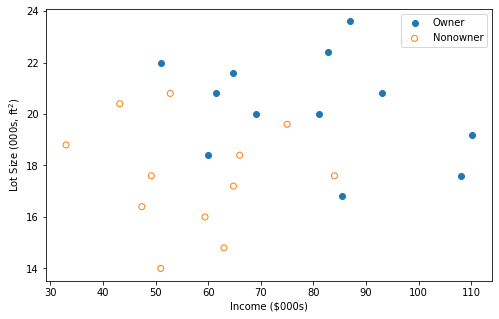

In [3]:
# plot first the data points for Ownership equals "Owner" and then of "Nonowner"
# setting color to "none" gives open circles

_, ax = plt.subplots(figsize=(8, 5))
for cat_value, color in [("Owner", "C0"), ("Nonowner", "C1")]:
    subset_df = mowers_df[mowers_df.Ownership == cat_value]
    if color == "C1":
        _color = "none"
    else:
        _color = color
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color=_color,
               edgecolor=color, marker="o", label=cat_value)

ax.legend()
ax.set_xlabel("Income ($000s)")
ax.set_ylabel("Lot Size (000s, ft$^2$)")
plt.show()

If we apply the classification tree procedure to these data, the procedure will choose Income for the first split with a splitting value of 60. The ($X_1$, $X_2$) space is now divided into two rectangles, one with Income ≤ 59.7 and the other with Income > 59.7. This is illustrated next:

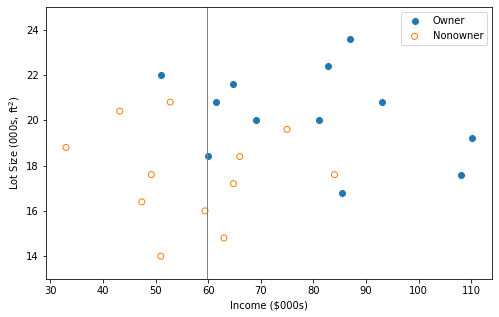

In [4]:
# plot first the data points for Ownership equals "Owner" and then of "Nonowner"
# setting color to "none" gives open circles

_, ax = plt.subplots(figsize=(8, 5))
for cat_value, color in [("Owner", "C0"), ("Nonowner", "C1")]:
    subset_df = mowers_df[mowers_df.Ownership == cat_value]
    if color == "C1":
        _color = "none"
    else:
        _color = color
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color=_color,
               edgecolor=color, marker="o", label=cat_value)

ax.plot([59.7, 59.7], [13, 25], linewidth=1, color="gray")
ax.legend()
ax.set_xlabel("Income ($000s)")
ax.set_ylabel("Lot Size (000s, ft$^2$)")
ax.set_ylim([13, 25])
plt.show()

Notice how the split has created two rectangles, each of which is much more homogeneous than the rectangle before the split. The left rectangle contains points that are mostly nonowners (7 nonowners and 1 owner) and the right rectangle contains mostly owners (11 owners and 5 nonowners).

How was this particular split selected? The algorithm examined each predictor variable (in this case, Income and Lot Size) and all possible split values for each variable to find the best split. What are the possible split values for a variable? They are simply the midpoints between pairs of consecutive values for the predictor. The possible split points for Income are {38.1, 45.3, 50.1, ..., 109.5} and those for Lot Size are {14.4, 15.4, 16.2, ..., 23}. These split points are ranked according to how much they reduce impurity (heterogeneity) in the resulting rectangle. A pure rectangle is one that is composed of a single class (e.g., owners). The reduction in impurity is defined as overall impurity before the split minus the sum of the impurities for the two rectangles that result from a split.

### Categorical Predictors

The previous description used numerical predictors; however, categorical predictors can also be used in the recursive partitioning context. To handle categorical predictors, the split choices for a categorical predictor are all ways in which the set of categories can be divided into two subsets. For example, a categorical variable with four categories, say {a, b, c, d}, can be split in seven ways into two subsets: {a} and {b, c, d}; {b} and {a, c, d}; {c} and {a, b, d}; {d} and {a, b, c}; {a, b} and {c, d}; {a, c} and {b, d}; and finally {a, d} and {b, c}. When the number of categories is large, the number of splits becomes very large. As with *k*-nearest-neighbors, a predictor with *m* categories (*m* > 2) should be factored into *m* dummies (not *m* - 1).

### Normalization

Whether predictors are numerical or categorical, it does not make any difference if they are standardized (normalized) or not.

### Measure of Impurity

There are a number of ways to measure impurity. The two most popular measures are the *Gini index* and an entropy measure. We describe both next. Denote the *m* classes of the response variable by *k* = 1, 2, ..., *m*.

The Gini impurity index for a rectangle *A* is defined by:

<p style="text-align:center">
    $I(A) = 1 - \sum \limits _{k=1}^{m} p^{2}_{k}$,
</p>

where $p_k$ is the proportion of records in rectangle A that belong to class *k*. This measure takes values between 0 (when all the records belong to the same class) and (*m* - 1)/*m* (when all *m* classes are equally represented).
The figure below shows the values of the Gini index for a two-class case as a function of $p_k$. It can be seen that the impurity measure is at its peak when $p_k$ = 0.5 (i.e., when the rectangle contains 50% of each of the two classes).

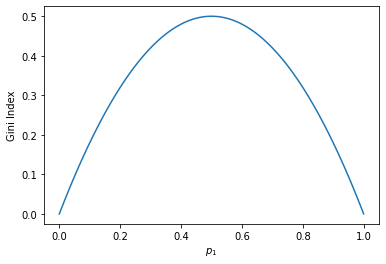

In [5]:
X = np.linspace(0, 1, 1001)
y = 1 - X*X - (1-X)*(1-X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("$p_1$")
ax.set_ylabel("Gini Index")
ax.plot(X, y)
plt.show()

A second impurity measure is the entropy measure. The entropy for a rectangle *A* is defined by:

<p style="text-align:center">
    $\text{entropy}(A) = 1 - \sum \limits _{k=1}^{m} p_{k} \log_{2}(p_{k})$,
</p>

(to compute $\log_2 (x)$ in Python, use function `math.log2(x)`). This measure ranges between 0 (most pure, all records belong to the same class) and $\log_2 (m)$ (when all *m* classes are represented equally). In the two-class case, the entropy measure is maximized (like the Gini index) at $p_k$ = 0.5.

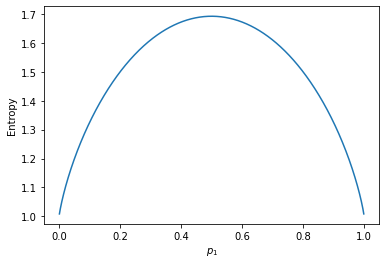

In [6]:
X = np.linspace(0.001, 0.999, 1001)
y = 1 - X*np.log(X) - (1-X)*np.log((1-X))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("$p_1$")
ax.set_ylabel("Entropy")
ax.plot(X, y)
plt.show()